In [682]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
from IPython.core.display import HTML
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.cross_validation import StratifiedKFold
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from scipy import interp

In [683]:
#reading the abstracts in to a Dataframes
mfgDf = pd.DataFrame.from_csv('../../data/positive_data.csv', index_col=None)
nsfDf = pd.DataFrame.from_csv('../../data/negative_data.csv', index_col=None)

In [684]:
#draw samples of 1000 from MFG and NON-MFG and add the flags
mfgDfSample = mfgDf.sample(1000)
mfgDfSample["sample_type"] = "MFG"

nsfDfSample = nsfDf.sample(1000)
nsfDfSample["sample_type"] = "NON-MFG"

In [685]:
#merging two dataframes to get a master data frame
#from which we will draw train and test samples
df = mfgDfSample.append(nsfDfSample)
df["txt"] = df["title"] + " " + df["abstract"]

In [686]:
#creating training and test hold out set
from sklearn.cross_validation import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(df['txt'].values.astype('U'), 
                                              (df["sample_type"]=="MFG").values,random_state=5)

In [687]:
#adding a few custom stop words to english stop words
from sklearn.feature_extraction import text
my_additional_stop_words = {'br', 'br br', 'project','based'}
stop_words = text.ENGLISH_STOP_WORDS.union(my_additional_stop_words)

In [688]:
#count vectorizer
from sklearn.feature_extraction.text import CountVectorizer
vectorizer =  CountVectorizer(ngram_range=(1, 2),token_pattern=r'\b\w+\b', min_df=1, 
                              stop_words=stop_words )

In [689]:
#creating a vect tranformer and vectorizing the training corpus
corpus = Xtrain
vectorizer = vectorizer.fit(corpus)
X = vectorizer.transform(corpus)
feature_names = np.asarray(vectorizer.get_feature_names())

In [690]:
#fitting a tfidf tranformer and tranforming the vector
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer()
tfidf_transformer = transformer.fit(X.toarray())
tfidf = tfidf_transformer.transform(X.toarray())

In [691]:
#training X and y
X_tfidf = tfidf.toarray()
y_target = ytrain

#hold out/test X and y
X_test_tfidf = tfidf_transformer.transform(vectorizer.transform(Xtest).toarray()).toarray()
y_test_target = ytest

In [692]:
#dimensionality reduction using Univariate statistics/selectKBest chi2
#http://scikit-learn.org/stable/modules/feature_selection.html
skb = SelectKBest(chi2, k=4000)

#creating training and test X for dimensionaly reduced data
X_dr_train = skb.fit_transform(X_tfidf, y_target)
X_dr_test = skb.transform(X_test_tfidf)

In [693]:
#feature_names_full = np.asarray([k for k,v in vectorizer.vocabulary_.items()])
#storing feature names (dimesionality reduced)
feature_names_dr = []
feature_names_dr = [ feature_names[i] for i in skb.get_support(indices=True)] 

In [694]:
############################################################################
### Using Logistic Regression                                             ##
############################################################################

In [695]:
#performing logistic regression on the dimensionally reduced data
from sklearn.linear_model import LogisticRegression
clf_dr = LogisticRegression()
clf_dr.fit(X_dr_train,y_target)
lr_dr_predicted = clf_dr.predict(X_dr_test)
lr_dr_predicted_prob = clf_dr.predict_proba(X_dr_test)
#calculating accuracy of the classifier
print(accuracy_score(lr_dr_predicted,y_test_target))

0.848


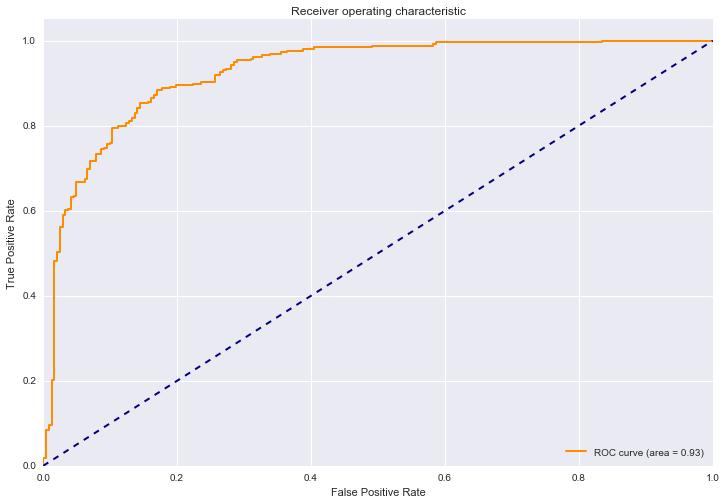

In [696]:
plotRocCurve(y_test_target, lr_dr_predicted_prob[:,1])

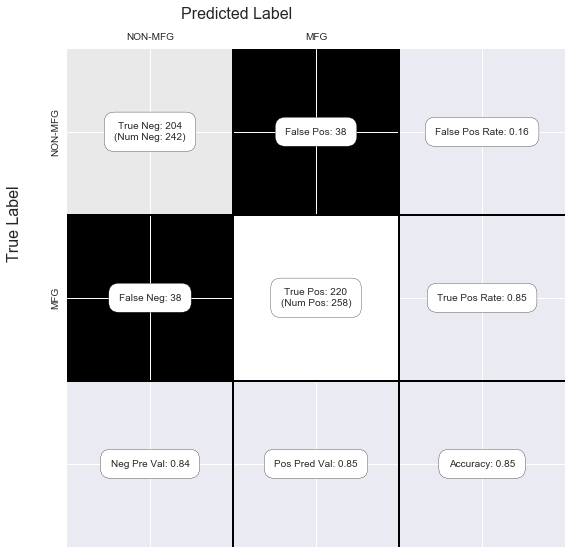

In [697]:
show_confusion_matrix(metrics.confusion_matrix(y_test_target, lr_dr_predicted),['NON-MFG','MFG'])

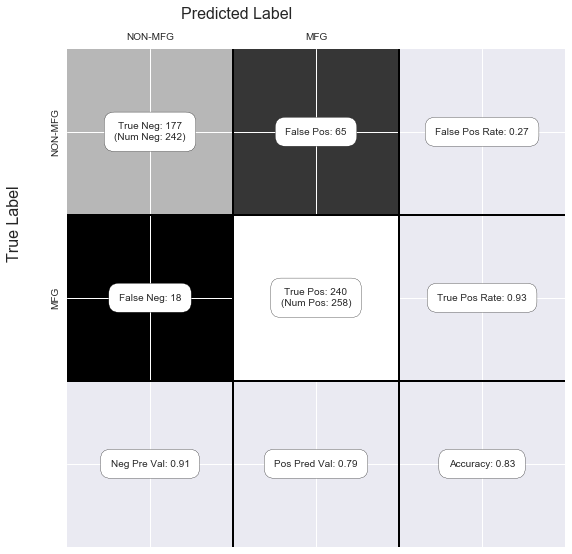

In [698]:
lr_dr_predicted_more_positive = (lr_dr_predicted_prob[:, 1] > (lr_dr_predicted_prob[:, 0] - 0.10))
show_confusion_matrix(metrics.confusion_matrix(y_test_target, lr_dr_predicted_more_positive),['NON-MFG','MFG'])

In [699]:
from sklearn.metrics import classification_report
ddddd = (lr_dr_predicted_prob[:, 1] > (lr_dr_predicted_prob[:, 0] - 0.10))
target_names = ["false", "true"]
print(classification_report(y_test_target, ddddd
                            , target_names=target_names))
np.mean(ddddd == y_test_target) 

             precision    recall  f1-score   support

      false       0.91      0.73      0.81       242
       true       0.79      0.93      0.85       258

avg / total       0.85      0.83      0.83       500



0.83399999999999996

In [700]:
############################################################################
### Using Multinomial classifier                                          ##
############################################################################

In [701]:
#performing multinomial NB on reduced data
from sklearn.naive_bayes import MultinomialNB
clf_mn_dr = MultinomialNB()
clf_mn_dr.fit(X_dr_train, y_target)
mn_dr_predicted = clf_mn_dr.predict(X_dr_test)
print(accuracy_score(mn_dr_predicted ,y_test_target))

0.86


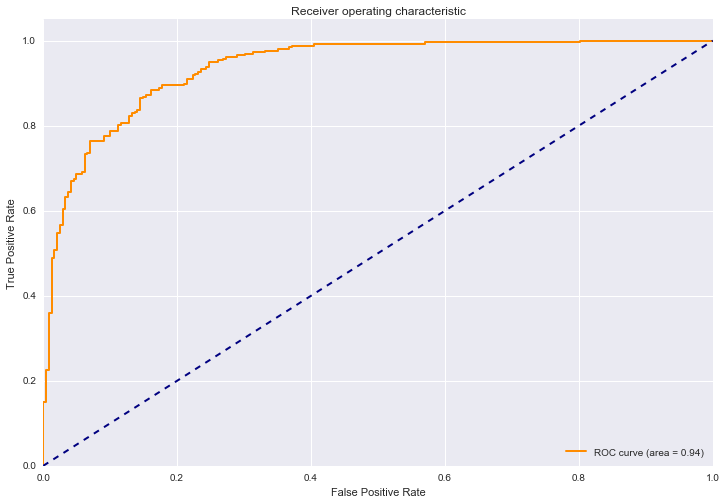

In [702]:
mn_dr_predic_prob = clf_mn_dr.predict_proba(X_dr_test)
plotRocCurve(y_test_target, mn_dr_predic_prob[:, 1])

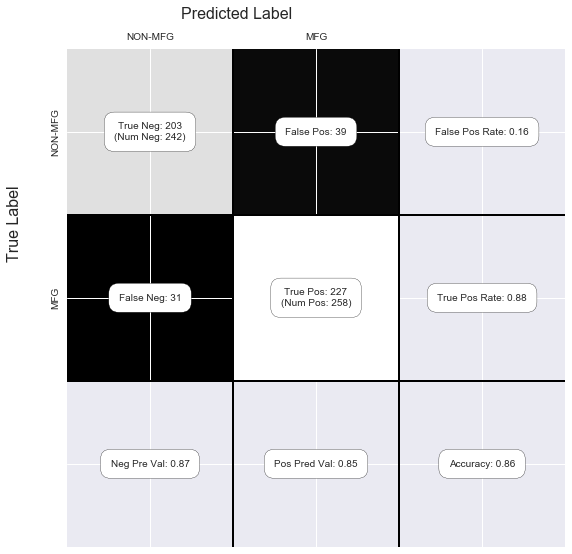

In [721]:
show_confusion_matrix(metrics.confusion_matrix(y_test_target, mn_dr_predicted),['NON-MFG','MFG'])

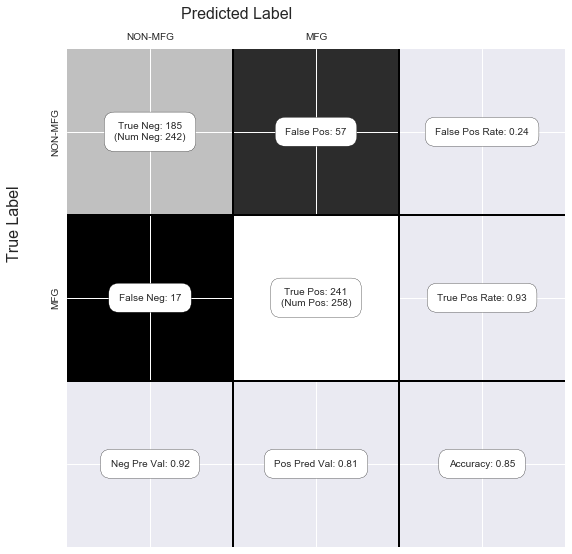

In [704]:
mn_dr_predicted_more_positive = (mn_dr_predic_prob[:, 1] > (mn_dr_predic_prob[:, 0] - 0.10))
show_confusion_matrix(metrics.confusion_matrix(y_test_target, mn_dr_predicted_more_positive),['NON-MFG','MFG'])

In [705]:
from sklearn.metrics import classification_report
ddddd = (mn_dr_predic_prob[:, 1] > (mn_dr_predic_prob[:, 0] - 0.045))
target_names = ["false", "true"]
print(classification_report(y_test_target, ddddd
                            , target_names=target_names))
np.mean(ddddd == y_test_target) 

             precision    recall  f1-score   support

      false       0.88      0.79      0.83       242
       true       0.82      0.90      0.86       258

avg / total       0.85      0.84      0.84       500



0.84399999999999997

In [706]:
############################################################################
### K Fold - Cross Validation using Multinomial classifier                ##
############################################################################

In [707]:
#ROC with cross validation to understand how different the samples could be
#X_dr_train = skb.fit_transform(X_tfidf, y_target)
skf = StratifiedKFold(y_target, n_folds=6, shuffle=True)
clf = MultinomialNB()

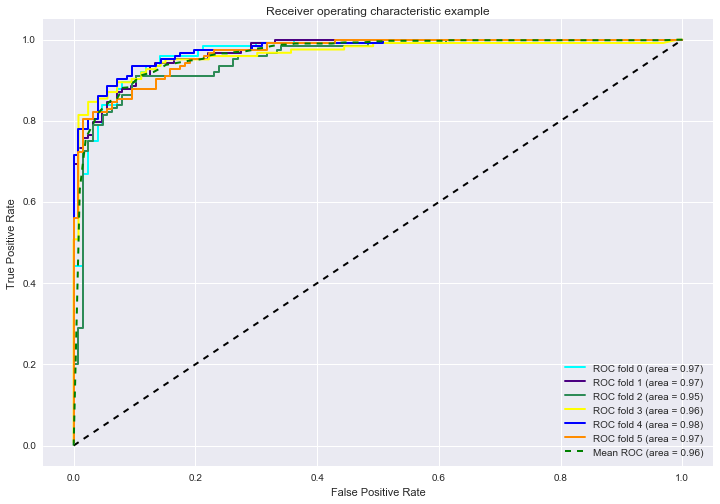

In [708]:
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange'])
lw = 2
i = 0
plt.figure(figsize=(12, 8))
for (train_index, test_index), color in zip(skf,colors):
    #print("TRAIN:", train_index, "TEST:", test_index)
    clf.fit(X_dr_train[train_index], y_target[train_index])
    probas_ = clf.predict_proba(X_dr_train[test_index])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_target[test_index], probas_[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=lw, color=color,
             label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
    i += 1
    
plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k')
mean_tpr /= skf.n_folds
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--',label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [709]:
print(accuracy_score(clf.predict(X_dr_test),y_test_target))

0.852


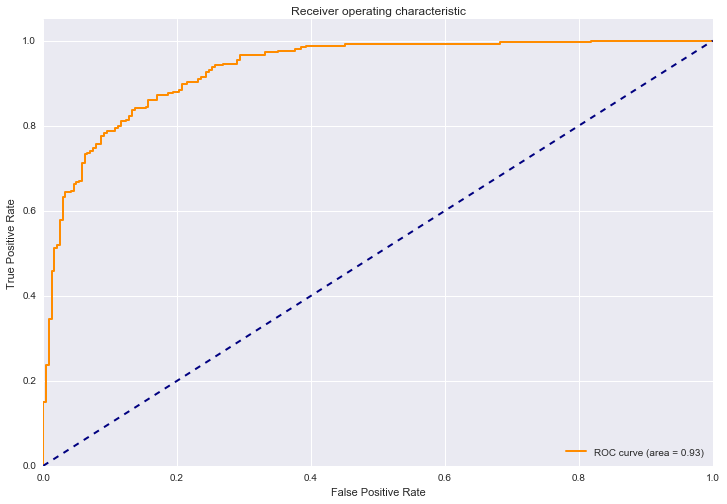

In [710]:
plotRocCurve(y_test_target, clf.predict_proba(X_dr_test)[:, 1])

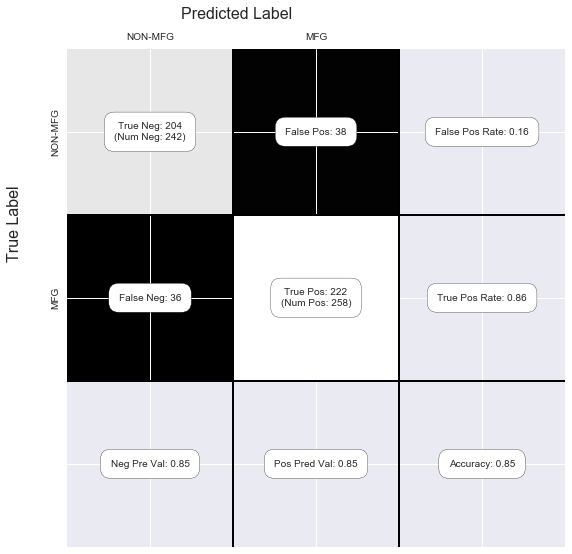

In [727]:
show_confusion_matrix(metrics.confusion_matrix(y_test_target, clf.predict(X_dr_test)),['NON-MFG','MFG'])

In [711]:
top10_feature_idx = (clf.coef_[0]).argsort()[-10:]
for idx in top10_feature_idx:
    print(feature_names_dr[idx])

approach
performance
tool
model
models
process
control
systems
manufacturing
design


In [712]:
########################################FUNCTIONS##########################################################
#function definition to plot ROC
def plotRocCurve(y, predictedProbabilities):
    fpr, tpr, thresholds = metrics.roc_curve(y, predictedProbabilities)
    roc_auc = metrics.auc(fpr,tpr)
    plt.figure(figsize=(12, 8))
    #plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
#http://notmatthancock.github.io/2015/10/28/confusion-matrix.html
def show_confusion_matrix(C,class_labels=['0','1']):
    """
    C: ndarray, shape (2,2) as given by scikit-learn confusion_matrix function
    class_labels: list of strings, default simply labels 0 and 1.

    Draws confusion matrix with associated metrics.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    assert C.shape == (2,2), "Confusion matrix should be from binary classification only."
    
    # true negative, false positive, etc...
    tn = C[0,0]; fp = C[0,1]; fn = C[1,0]; tp = C[1,1];

    NP = fn+tp # Num positive examples
    NN = tn+fp # Num negative examples
    N  = NP+NN

    fig = plt.figure(figsize=(8,8))
    ax  = fig.add_subplot(111)
    ax.imshow(C, interpolation='nearest', cmap=plt.cm.gray)

    # Draw the grid boxes
    ax.set_xlim(-0.5,2.5)
    ax.set_ylim(2.5,-0.5)
    ax.plot([-0.5,2.5],[0.5,0.5], '-k', lw=2)
    ax.plot([-0.5,2.5],[1.5,1.5], '-k', lw=2)
    ax.plot([0.5,0.5],[-0.5,2.5], '-k', lw=2)
    ax.plot([1.5,1.5],[-0.5,2.5], '-k', lw=2)

    # Set xlabels
    ax.set_xlabel('Predicted Label', fontsize=16)
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(class_labels + [''])
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    # These coordinate might require some tinkering. Ditto for y, below.
    ax.xaxis.set_label_coords(0.34,1.06)

    # Set ylabels
    ax.set_ylabel('True Label', fontsize=16, rotation=90)
    ax.set_yticklabels(class_labels + [''],rotation=90)
    ax.set_yticks([0,1,2])
    ax.yaxis.set_label_coords(-0.09,0.65)


    # Fill in initial metrics: tp, tn, etc...
    ax.text(0,0,
            'True Neg: %d\n(Num Neg: %d)'%(tn,NN),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,1,
            'False Neg: %d'%fn,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,0,
            'False Pos: %d'%fp,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    ax.text(1,1,
            'True Pos: %d\n(Num Pos: %d)'%(tp,NP),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    # Fill in secondary metrics: accuracy, true pos rate, etc...
    ax.text(2,0,
            'False Pos Rate: %.2f'%(fp / (fp+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,1,
            'True Pos Rate: %.2f'%(tp / (tp+fn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,2,
            'Accuracy: %.2f'%((tp+tn+0.)/N),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,2,
            'Neg Pre Val: %.2f'%(1-fn/(fn+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,2,
            'Pos Pred Val: %.2f'%(tp/(tp+fp+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    plt.tight_layout()
    plt.show()